In [46]:
import os
import pandas as pd
import sys



In [ ]:
PROJECT_ROOT = "/content/chest-xray-covid-classifier"
sys.path.insert(0, PROJECT_ROOT)

Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("praveengovi/coronahack-chest-xraydataset")

print("Path to dataset files:", path)


100%|██████████| 1.19G/1.19G [00:41<00:00, 30.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/praveengovi/coronahack-chest-xraydataset/versions/3


In [35]:
df = pd.read_csv('/content/dataset/Chest_xray_Corona_Metadata.csv')


In [41]:
train_dir = "/content/dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
test_dir = "/content/dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"

In [43]:
train_labels = df[df["Dataset_type"] == "TRAIN"].reset_index(drop=True)
test_labels  = df[df["Dataset_type"] == "TEST"].reset_index(drop=True)

Exploratory Data Analysis

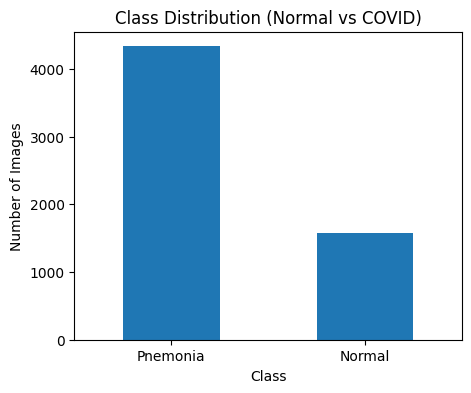

In [36]:
import matplotlib.pyplot as plt

# Overall class distribution
class_counts = df['Label'].value_counts()

plt.figure(figsize=(5,4))
class_counts.plot(kind='bar')
plt.title("Class Distribution (Normal vs COVID)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()


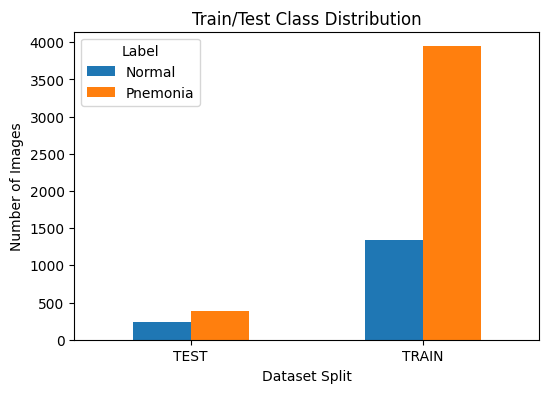

In [38]:
split_counts = df.groupby(['Dataset_type', 'Label']).size().unstack()

split_counts.plot(kind='bar', figsize=(6,4))
plt.title("Train/Test Class Distribution")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()


In [39]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def show_sample_images(df, image_dir, label_name, n=4):
    samples = df[df['Label'] == label_name].sample(n)

    plt.figure(figsize=(10,4))
    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(image_dir, row['X_ray_image_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label_name)

    plt.show()


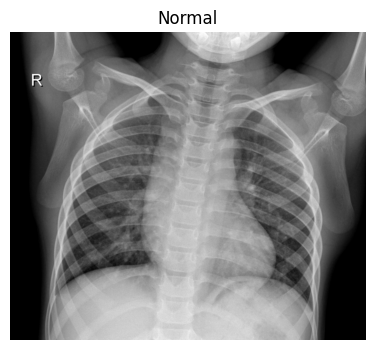

In [44]:
# Show Normal samples
show_sample_images(train_labels, train_dir, "Normal", n=1)




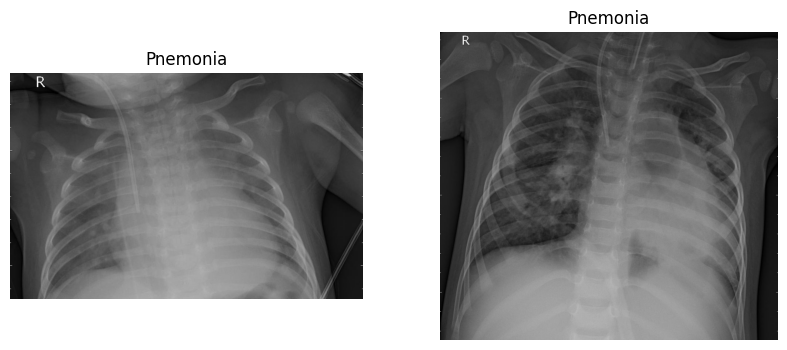

In [45]:
# Show Pnemonia samples
show_sample_images(train_labels, train_dir, "Pnemonia", n=2)

In [22]:
import sys, os
sys.path.append(os.path.abspath(".."))

from src.data import create_generators
from src.model import build_model
from src.train import train_frozen, fine_tune
from src.evaluate import evaluate

print("Imports successful")


Imports successful


In [29]:
train_gen, val_gen, test_gen = create_generators(
    csv_path="/content/dataset/Chest_xray_Corona_Metadata.csv",
    train_dir= train_dir,
    test_dir=test_dir,

    batch_size=32
)


Found 4758 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [30]:
model, base_model = build_model()
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
history_frozen = train_frozen(
    model,
    train_gen,
    val_gen,
    epochs=6
)


In [ ]:
history_finetune = fine_tune(
    model,
    base_model,
    train_gen,
    val_gen,
    epochs=8
)


In [ ]:
test_loss, test_acc = evaluate(model, test_gen)
print("Final Test Accuracy:", test_acc)
